In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns

#pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from cross_validation import *

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

actual_values_dict = {}

for store in range(1, 46):
    store_df = df[df['store'] == store].copy()
    store_df.sort_values('date', inplace=True)
    store_df.set_index('date', inplace=True)

    actual_values_dict[store] = store_df['weekly_sales']

Modell wählen

In [3]:
model_type = 'SARIMA'
#model_type = 'Naive'

Alle Residuen und Fitted Values berechnen

In [ ]:
fitted_values_dict = {}
residuals_dict = {}

if model_type == 'Naive':
    residuals_dict, fitted_values_dict = naive_for_all_stores('Walmart_Sales.csv')

if model_type == 'SARIMA':
    sarima_models = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 5)


Store 1: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 2: Modell erstellt mit Order (4, 0, 3) und Seasonal Order (1, 0, 1, 52)
Store 3: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (2, 0, 0, 52)
Store 4: Modell erstellt mit Order (2, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 5: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 6: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 7: Modell erstellt mit Order (0, 1, 1) und Seasonal Order (0, 1, 0, 52)
Store 8: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 9: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 10: Modell erstellt mit Order (4, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 11: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 12: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 13: Modell erstellt mit Order (2, 0, 2) und Seasonal Or

In [ ]:
if model_type == 'SARIMA':
    for store in range(1, 46):
        model = sarima_models.get(store)
        fitted_values_dict[store] = model.fittedvalues
        residuals_dict[store] = model.resid.iloc[52:] # remove first value because it is 0

if model_type == 'Naive':
    for store in range(1,46):
        residuals_dict[store].iloc[51:]

#pd.set_option('display.max_rows', None)
print(residuals_dict[1])
print(len(residuals_dict[1]))

date
2011-02-04   -377319.196195
2011-02-11    -67217.868423
2011-02-18    -25154.127411
2011-02-25   -174054.713710
2011-03-04      8137.647751
                  ...      
2012-09-28    -80846.123643
2012-10-05     76152.727206
2012-10-12    -10201.022213
2012-10-19    -66187.987846
2012-10-26    -16633.953697
Freq: W-FRI, Length: 91, dtype: float64
91


Residuen

1452.9294278649168


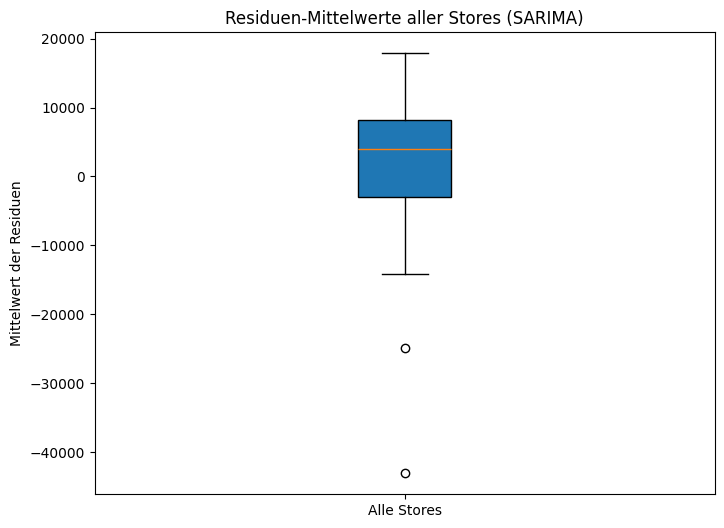

In [21]:
resid_means = []
for store in sorted(residuals_dict.keys(), key=int):
    mean_resid = residuals_dict[store].mean()
    resid_means.append(mean_resid)

#print(resid_means)
print(sum(resid_means) / len(resid_means))

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(resid_means, patch_artist=True)
plt.title('Residuen-Mittelwerte aller Stores ({})'.format(model_type))
plt.ylabel("Mittelwert der Residuen")
plt.xticks([1], ["Alle Stores"])
plt.show()

Korrelations Tests

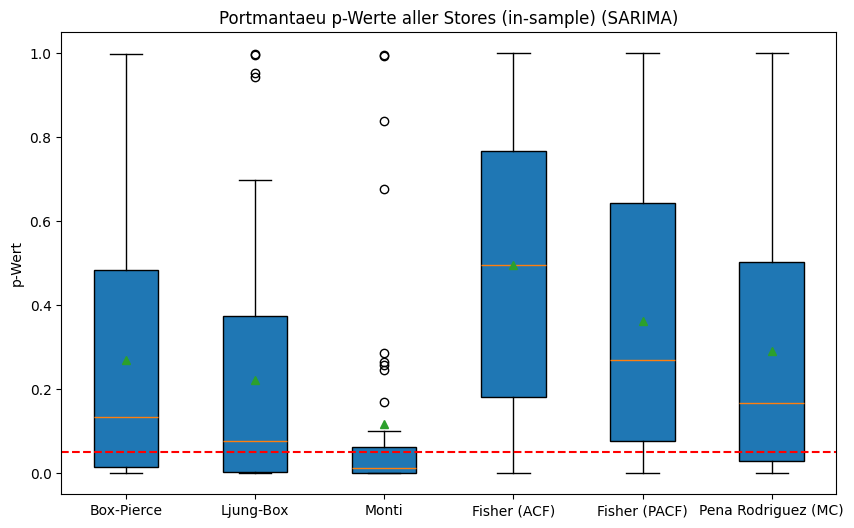

0.2707753204929432 0.22201518381972096 0.1184831095067418 0.4963367842193606 0.3627884122299945 0.29177489177489174
0.13488335122470832 0.07727622369098446 0.013283590851679516 0.4963988062685142 0.2706551736523186 0.16683316683316685


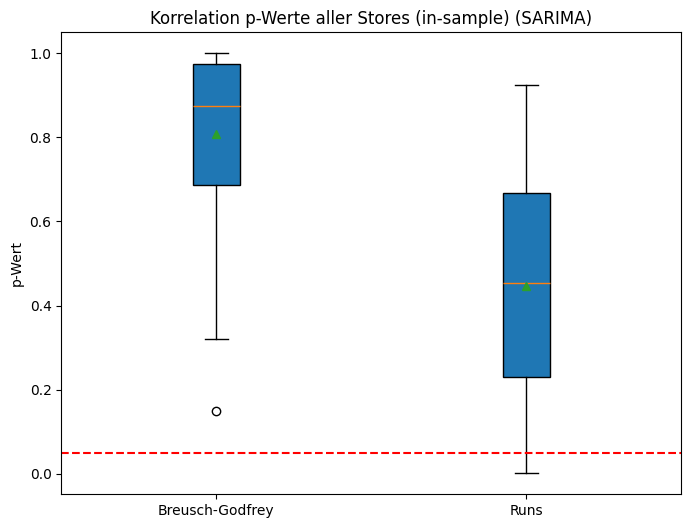

0.8086067646887904 0.44582083193946337
0.873661497227636 0.45376112005963876


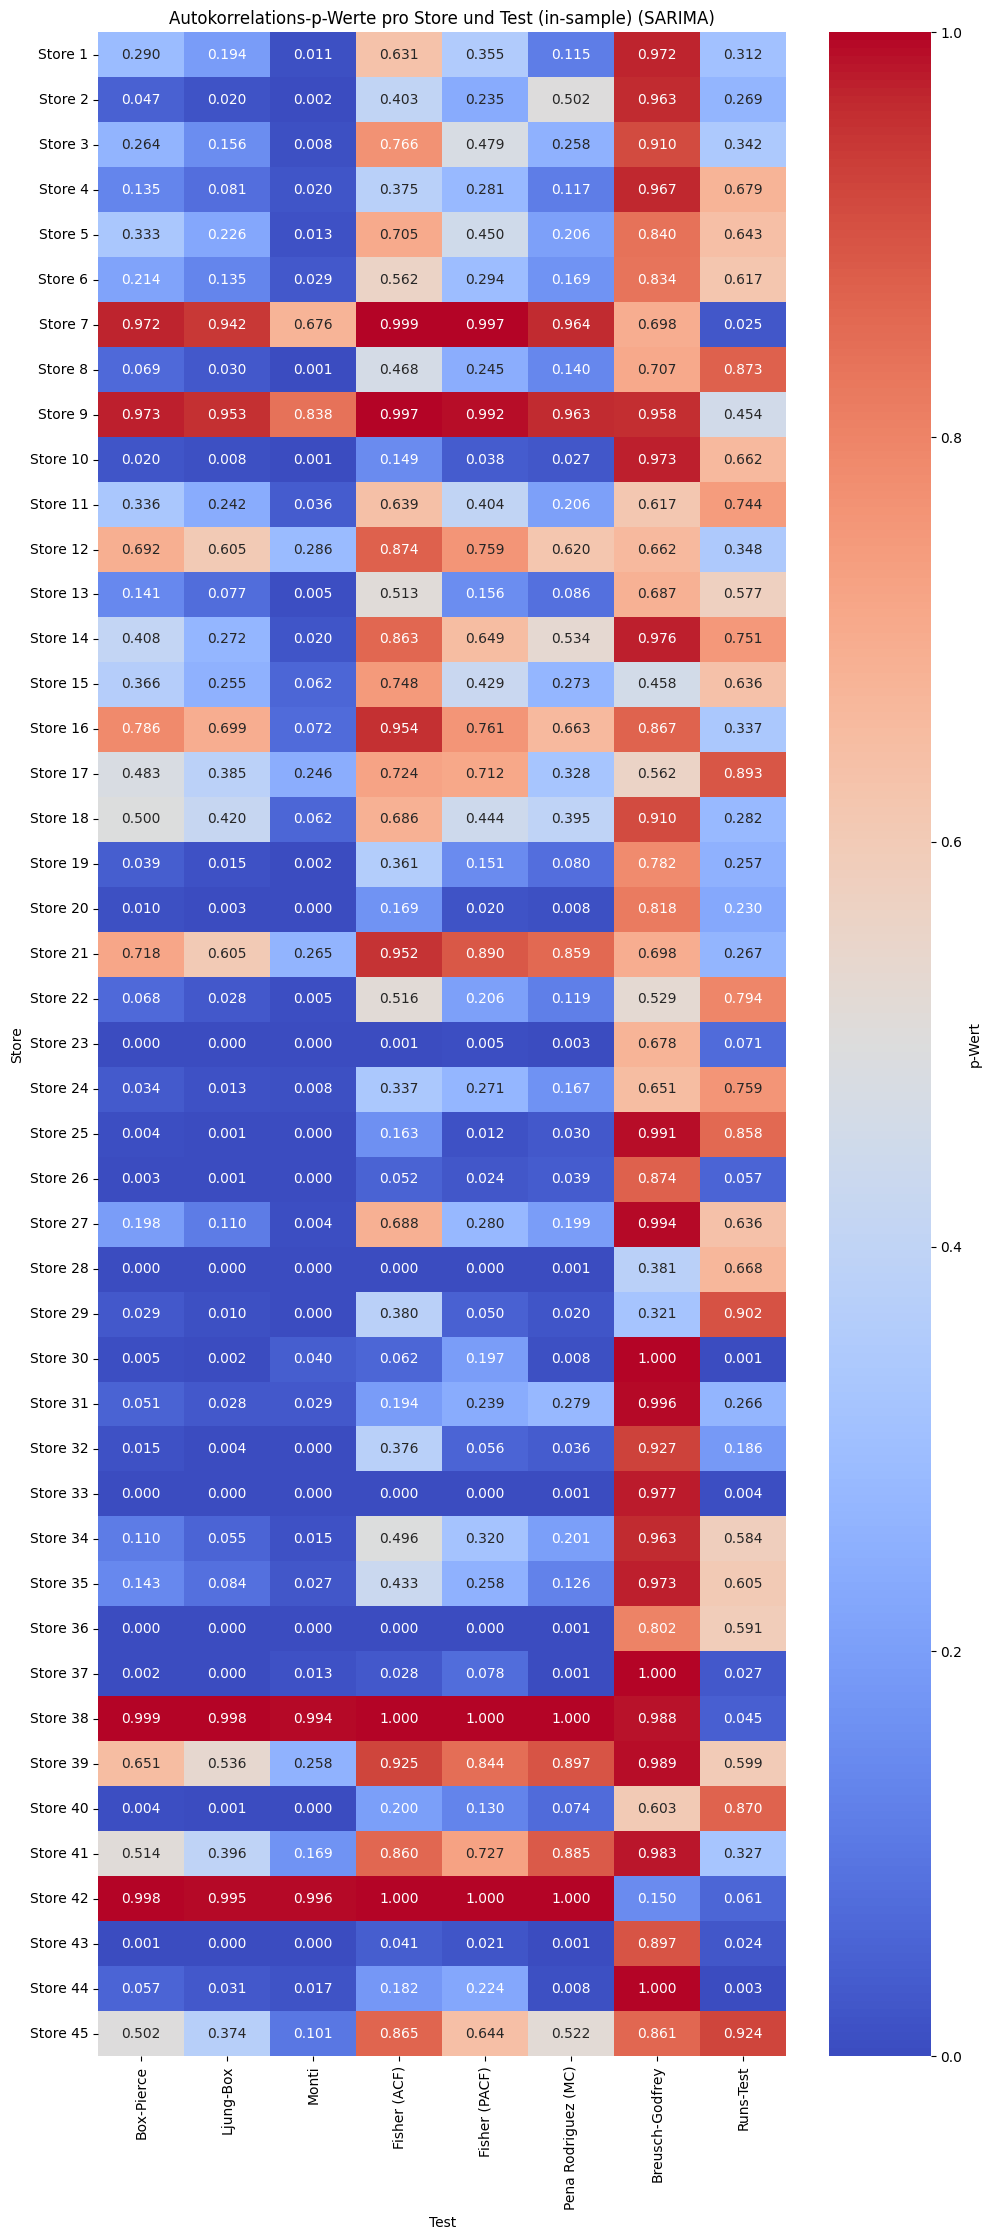

In [33]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags = 18, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags=18, print_results = False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            if model_type == 'SARIMA':
                _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 18, print_results = False)
            if model_type == 'Naive':
                _, p_value = breusch_godfrey_test_naive(sales, lags = 5, print_results = False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = resid, store_num=store, model = model_type, m = 18, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "acf", m = 18, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "pacf", m = 18, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = resid, m = 18, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)

        # Runs Test
        try:
            _, p_value = run_test(residuals = resid, print_results = False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)



pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

print(np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))
print(np.median(bp_pvalues), np.median(lb_pvalues),  np.median(m_pvalues), np.median(f_pvalues), np.median(f2_pvalues), np.median(pr2_pvalues))


# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True)
plt.title('Korrelation p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

print(np.mean(bg_pvalues), np.mean(rt_pvalues))
print(np.median(bg_pvalues), np.median(rt_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)", "Breusch-Godfrey", "Runs-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelations-p-Werte pro Store und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()





Durbin Watson

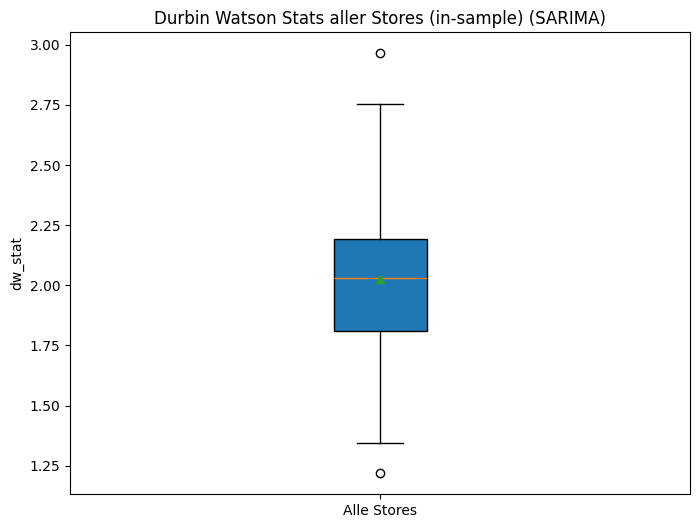

2.0258726253064028


In [23]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()

print(np.mean(dw_stats))


Mittelwert Tests

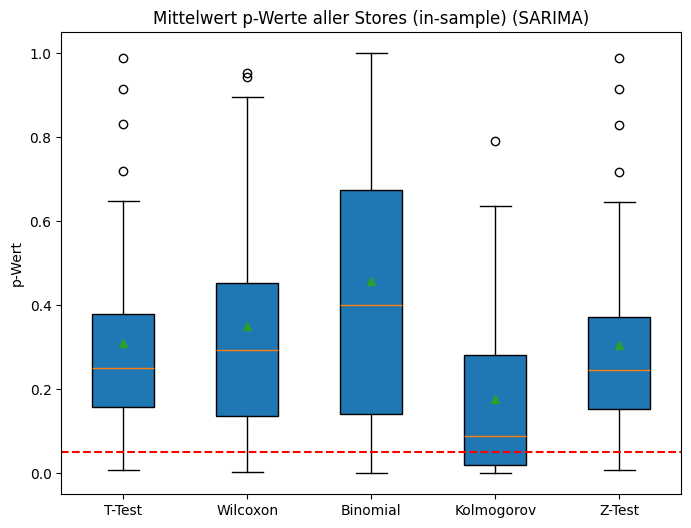

In [26]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(resid, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues, z_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov", "Z-Test"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

SMAPE

[7.20693929007591, 6.064320851919651, 6.941833934557422, 6.973881693753432, 7.3756466556755775, 6.697611740863714, 8.159724579721244, 6.23306769250705, 7.621455524164664, 6.834293810667491, 6.899593337561952, 6.559381219110398, 6.434809231131609, 8.58090826275572, 7.938497026739013, 7.282448405633597, 8.450285897990371, 8.868299701999085, 7.068499558304904, 7.439191277352182, 7.35874247102188, 7.631683673283206, 8.833526331996048, 7.476358507505224, 7.3234888706362025, 6.529082436153924, 7.792179931767413, 8.91472056300329, 8.671007454756053, 4.772210071643798, 5.121420087468328, 5.726090120994855, 5.661188368935414, 5.601157995775415, 10.83668741924653, 5.933269214296089, 4.782702452335086, 6.992426686777882, 7.9361626317991565, 7.455382286642226, 8.030461114820616, 7.527810445609201, 6.2464588180722584, 5.5516531081273035, 7.6087048908790935]


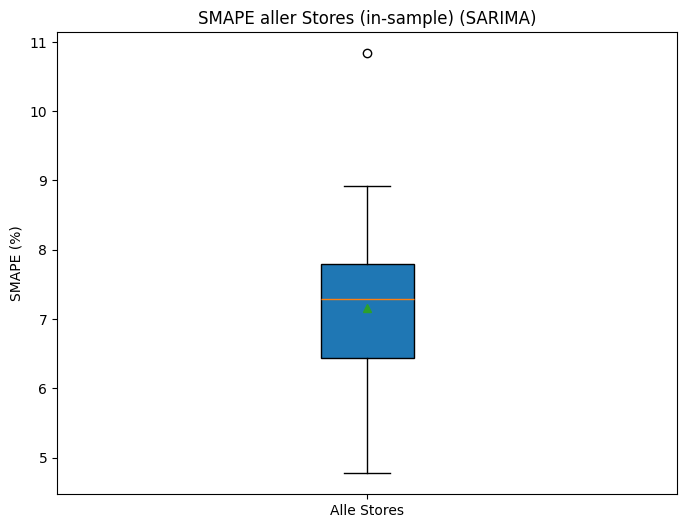

Durchschnittlicher SMAPE über alle Stores: 7.15 %


In [27]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

smape_stats = []

for store_id in range(1, 46):
    # fitted_values holen und in Serie umwandeln
    fitted = fitted_values_dict.get(store_id)
    if fitted is None:
        smape_stats.append(np.nan)
        continue

    # Sales-Daten für den Store
    store_df = df[df['store'] == store_id].copy()
    store_df.set_index('date', inplace=True)
    sales = store_df['weekly_sales'].asfreq('W-FRI')

    # fitted in Serie mit gleichem Index überführen
    y_pred = pd.Series(fitted, index=sales.index, name='pred')
    y_true = sales.rename('true')

    # nur Wochen, wo beide Werte vorliegen
    mask = y_pred.notna() & y_true.notna()

    y_pred_clean = y_pred[mask]
    y_true_clean = y_true[mask]

    # SMAPE
    numerator   = np.abs(y_pred_clean - y_true_clean)
    denominator = (np.abs(y_pred_clean) + np.abs(y_true_clean)) / 2

    smape_array = np.where(denominator == 0, 0, numerator / denominator)
    smape = np.nanmean(smape_array) * 100

    smape_stats.append(smape)

print(smape_stats)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

print("Durchschnittlicher SMAPE über alle Stores: {:.2f} %".format(np.nanmean(smape_stats)))

SMAPE vs. Autokorrelation p-Werte

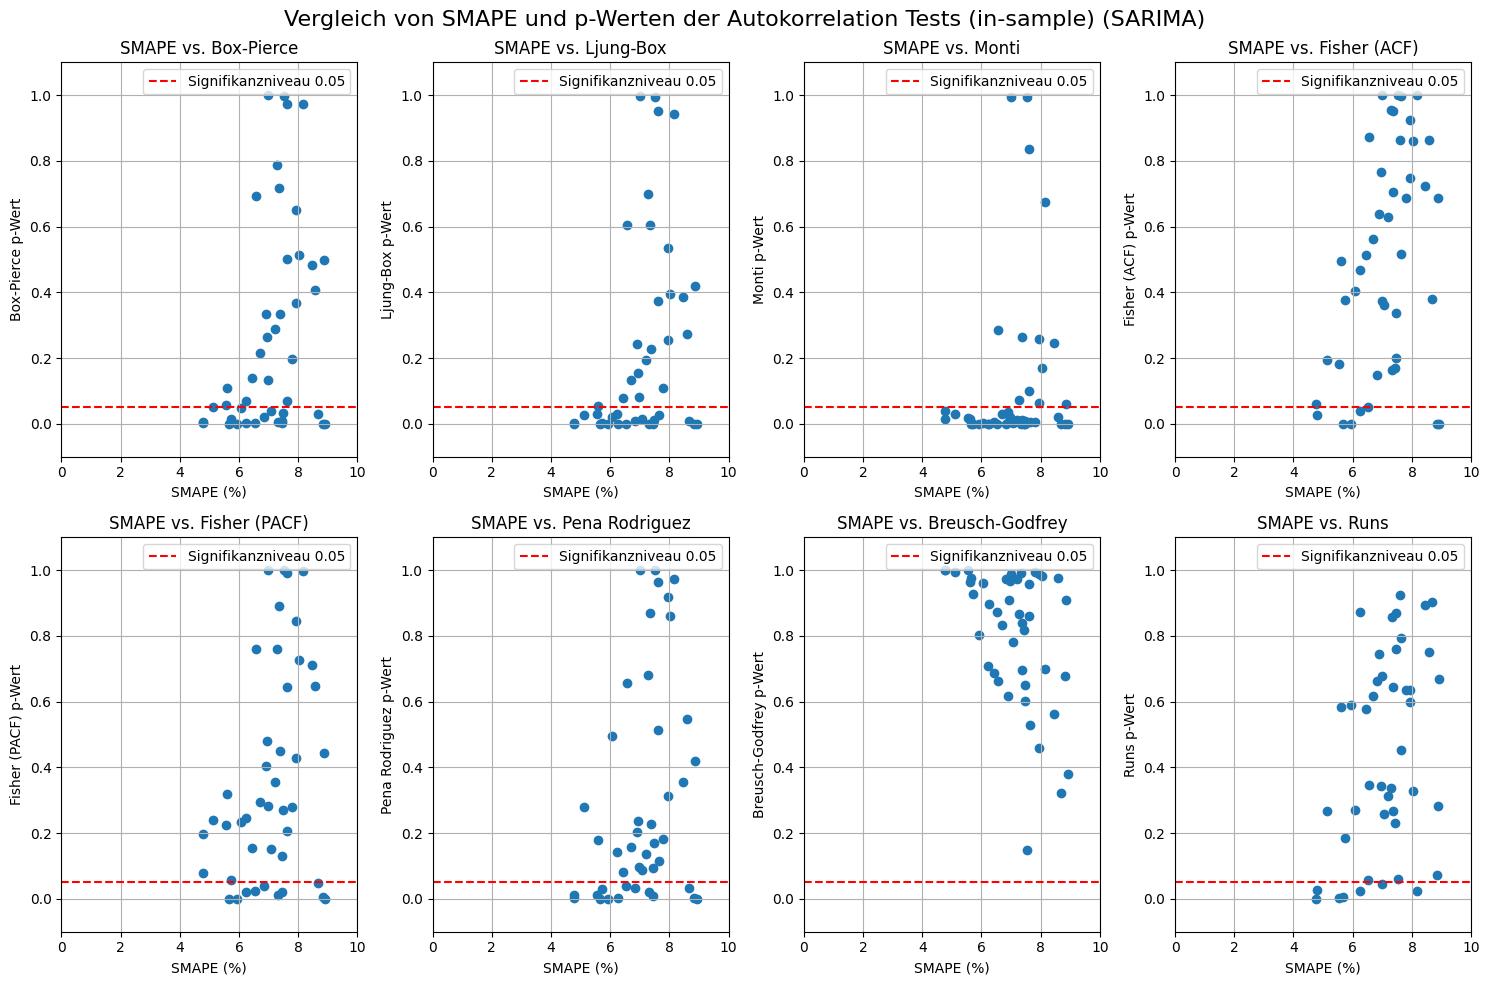

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 Zeilen, 4 Spalten


p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (in-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
plt.show()

SMAPE vs Mittelwert p-Werte

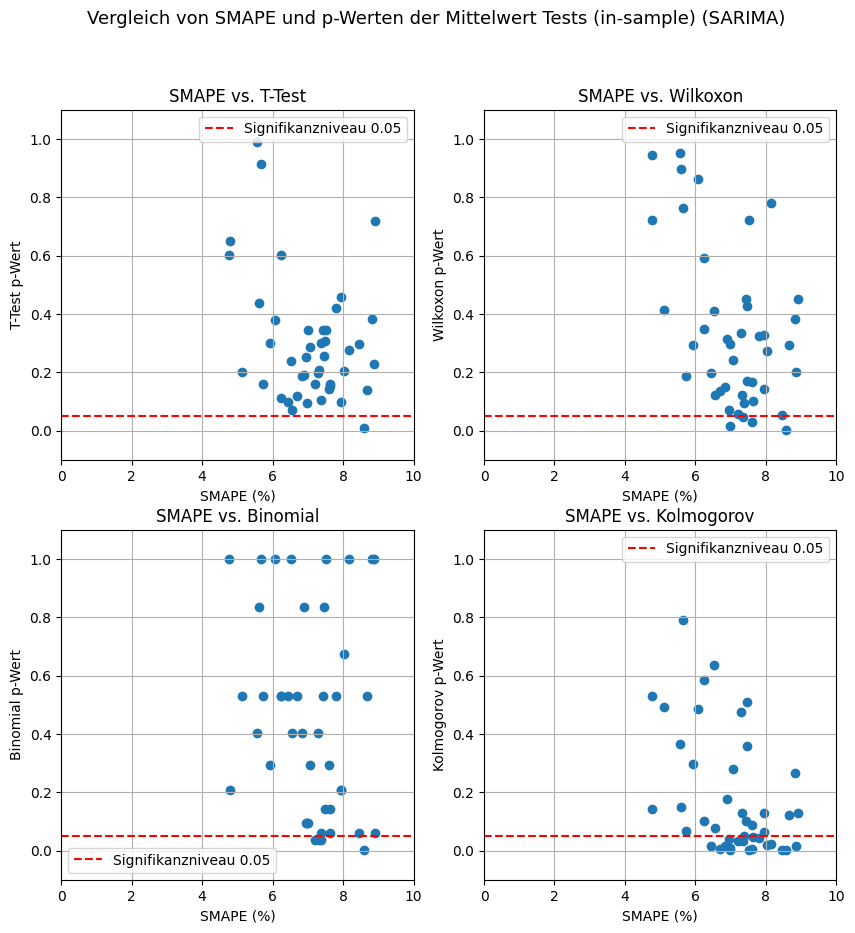

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (in-sample) ({})'.format(model_type), fontsize=13)
plt.show()

Kreuzvalidierung

In [ ]:
if model_type == 'SARIMA':
    cvs = cv_SARIMA_all_stores('Walmart_Sales.csv', whichorder = 5)
if model_type == 'Naive':
    cvs = cv_naive_all_stores('Walmart_Sales.csv')

Verarbeite Store 1 (Datenlänge: 143)...
Cross-Validation RMSE: 112385.86388991041
Verarbeite Store 2 (Datenlänge: 143)...


KeyboardInterrupt: 

Errors

25461.58471264368


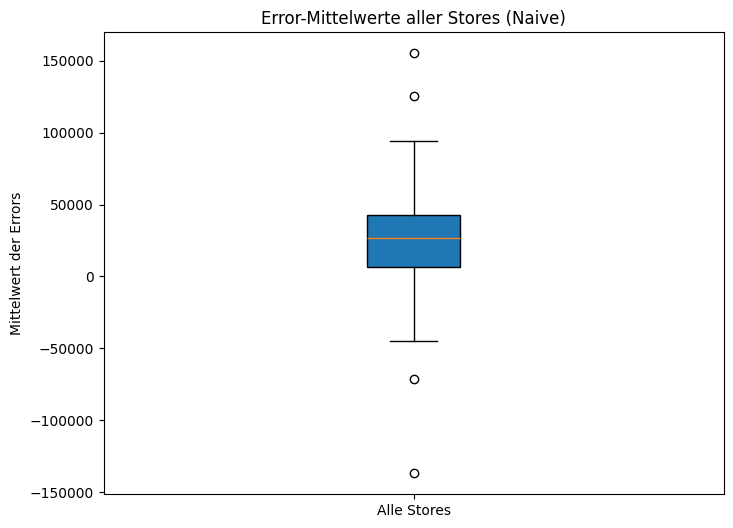

In [ ]:
error_means = cvs.groupby('store')['error'].mean()

print(sum(error_means) / len(error_means))


plt.figure(figsize=(8, 6))
plt.boxplot(error_means.values, patch_artist=True)
plt.ylabel('Mittelwert der Errors')
plt.title('Error-Mittelwerte aller Stores ({})'.format(model_type))
plt.xticks([1], ["Alle Stores"])
plt.show()


In [ ]:
errors = cvs[cvs['store'] == 1]['error']
print(errors)
print(len(errors))

0      28229.24
1     -58767.67
2     122750.02
3      34116.83
4     157108.78
5      61039.87
6     145570.30
7     100459.40
8      55699.52
9      77696.55
10     36050.17
11    117068.12
12     -9858.26
13   -117761.21
14    130142.71
15    105637.64
16     68587.21
17     66988.42
18      2426.28
19     29710.07
20    152862.50
21    133027.22
22     82587.55
23     52157.35
24    122239.53
25    100654.72
26    -30034.31
27    154539.88
28    285417.53
29     61142.70
30    -43241.94
31     13837.68
32     55128.71
33      6320.47
34    167683.60
35     89397.88
36    -10600.83
37    108282.64
38     98492.14
39     89015.66
40     51883.40
41    235004.52
42     71894.07
43    101027.94
44     86903.92
45      6752.04
46     67262.88
47     67106.62
48     29428.92
49     31854.18
50    121296.09
51      3169.09
52    126105.79
53     42497.43
54     39796.02
55     79546.88
56      5505.99
57     48410.65
Name: error, dtype: float64
58


Korrelations Test

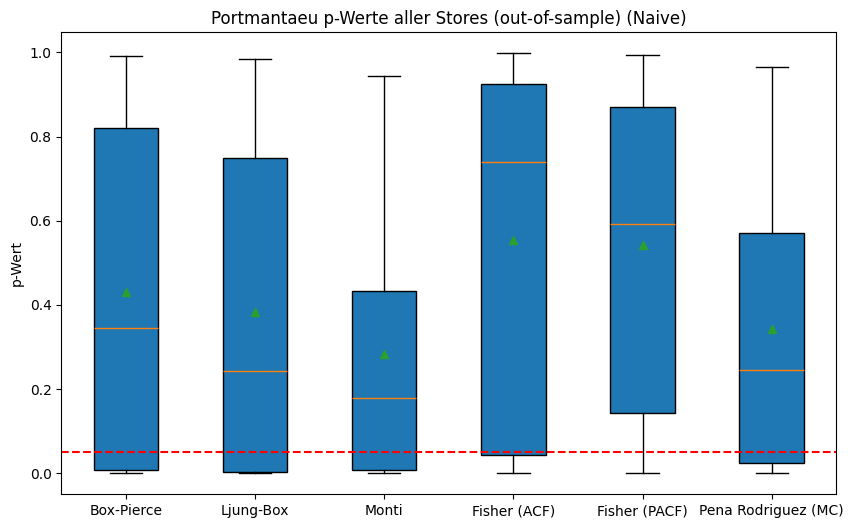

0.4304318477155982 0.38347712923184624 0.28398852343887004 0.5543777103560628 0.5414673163220777 0.3423687423687424


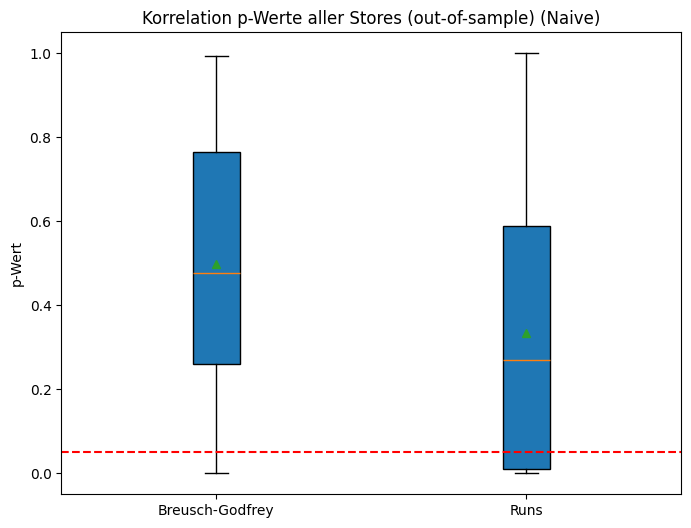

0.4983663678860326 0.3351471920187083


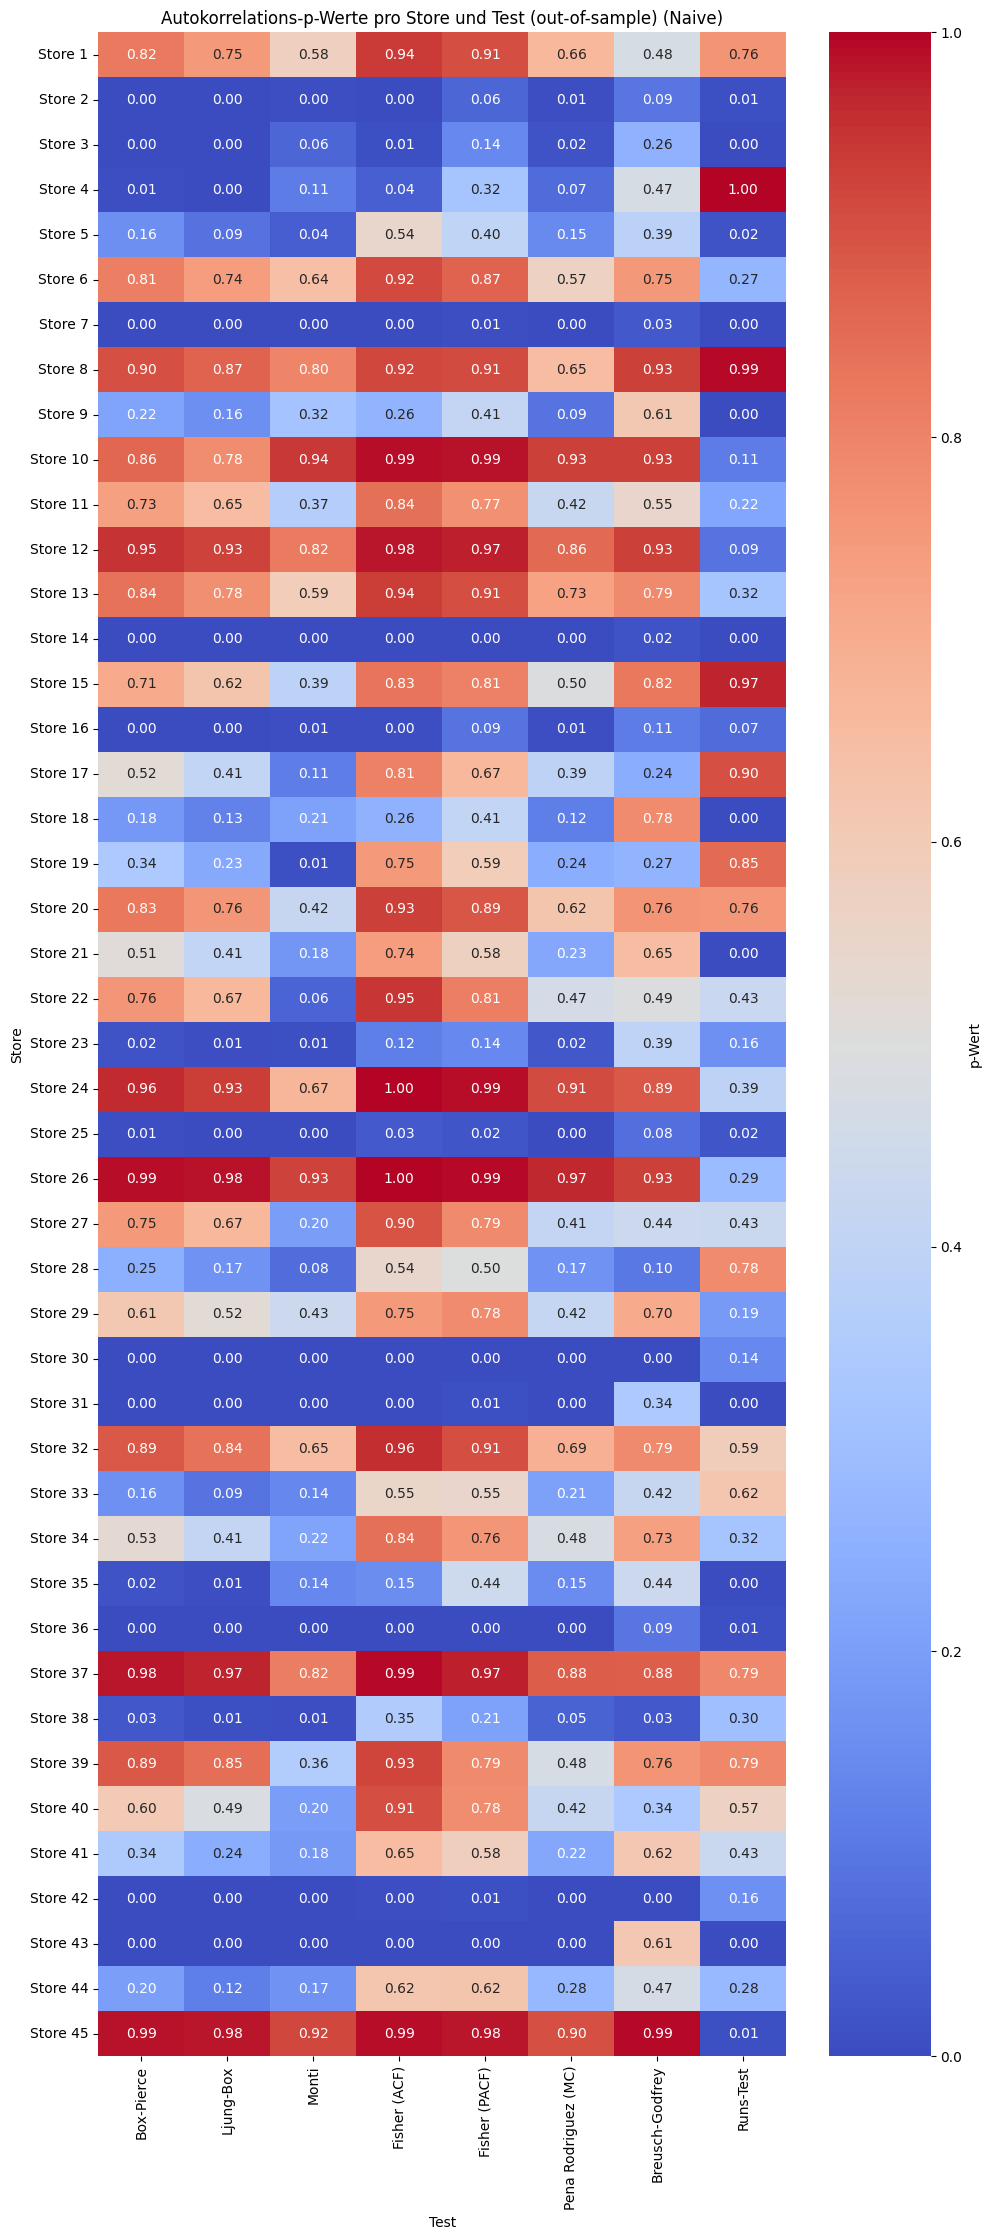

In [ ]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []


# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    
    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 10, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 10, print_results=False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_oos(residuals=errors, lags = 10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = monti_test(residuals = errors, store_num = store, model = model_type, m = 9, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "acf", m = 9, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "pacf", m = 9, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = errors, m = 9, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = errors, print_results=False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

print(np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))


# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True)
plt.title('Korrelation p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

print(np.mean(bg_pvalues), np.mean(rt_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)", "Breusch-Godfrey", "Runs-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelations-p-Werte pro Store und Test (out-of-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


Durbin Watson

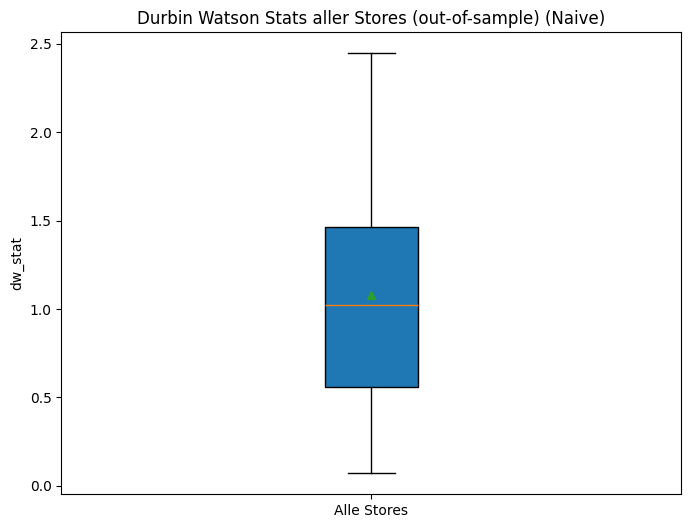

In [ ]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = cvs[cvs['store'] == store]['error']
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()


Mittelwert Tests

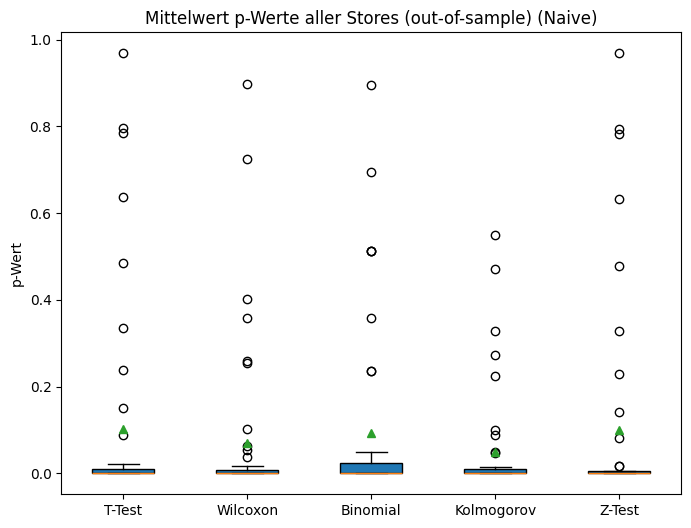

In [ ]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(errors, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues, z_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov", "Z-Test"])
plt.show()



SMAPE

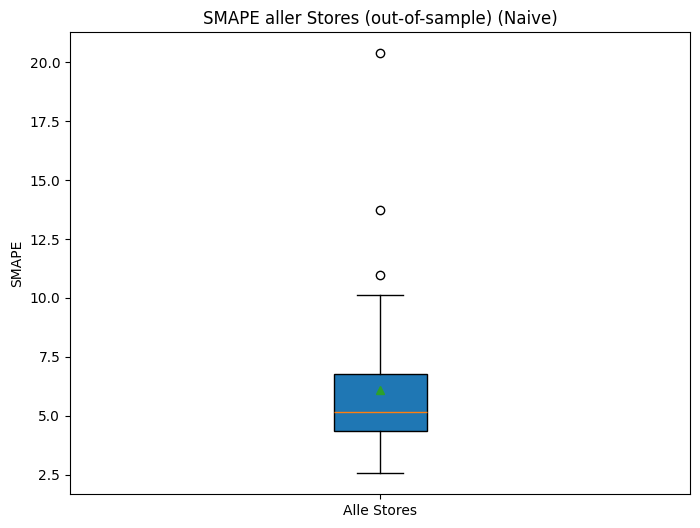

6.088989717718031


In [ ]:
smape_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    forecast_values = cvs[cvs['store'] == store]['forecast']
    actual_values = cvs[cvs['store'] == store]['actual']

    if len(forecast_values) > 0:
        # SMAPI Test
    
        numerator = np.abs(forecast_values - actual_values)
        denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
        smape = np.where(denominator == 0, 0, numerator / denominator)
        smape = np.mean(smape) * 100
        try:
            smape_stats.append(smape)
        except Exception as e:
            print(f"Fehler beim SMAPI Test für Store {store}: {e}")
            smape_stats.append(np.nan)
    else:
        smape_stats.append(np.nan)

plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title('SMAPE aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("SMAPE")
plt.xticks([1], ["Alle Stores"])
plt.show()

print(np.mean(smape_stats))

SMAPE vs. Autokorrelation p-Werte

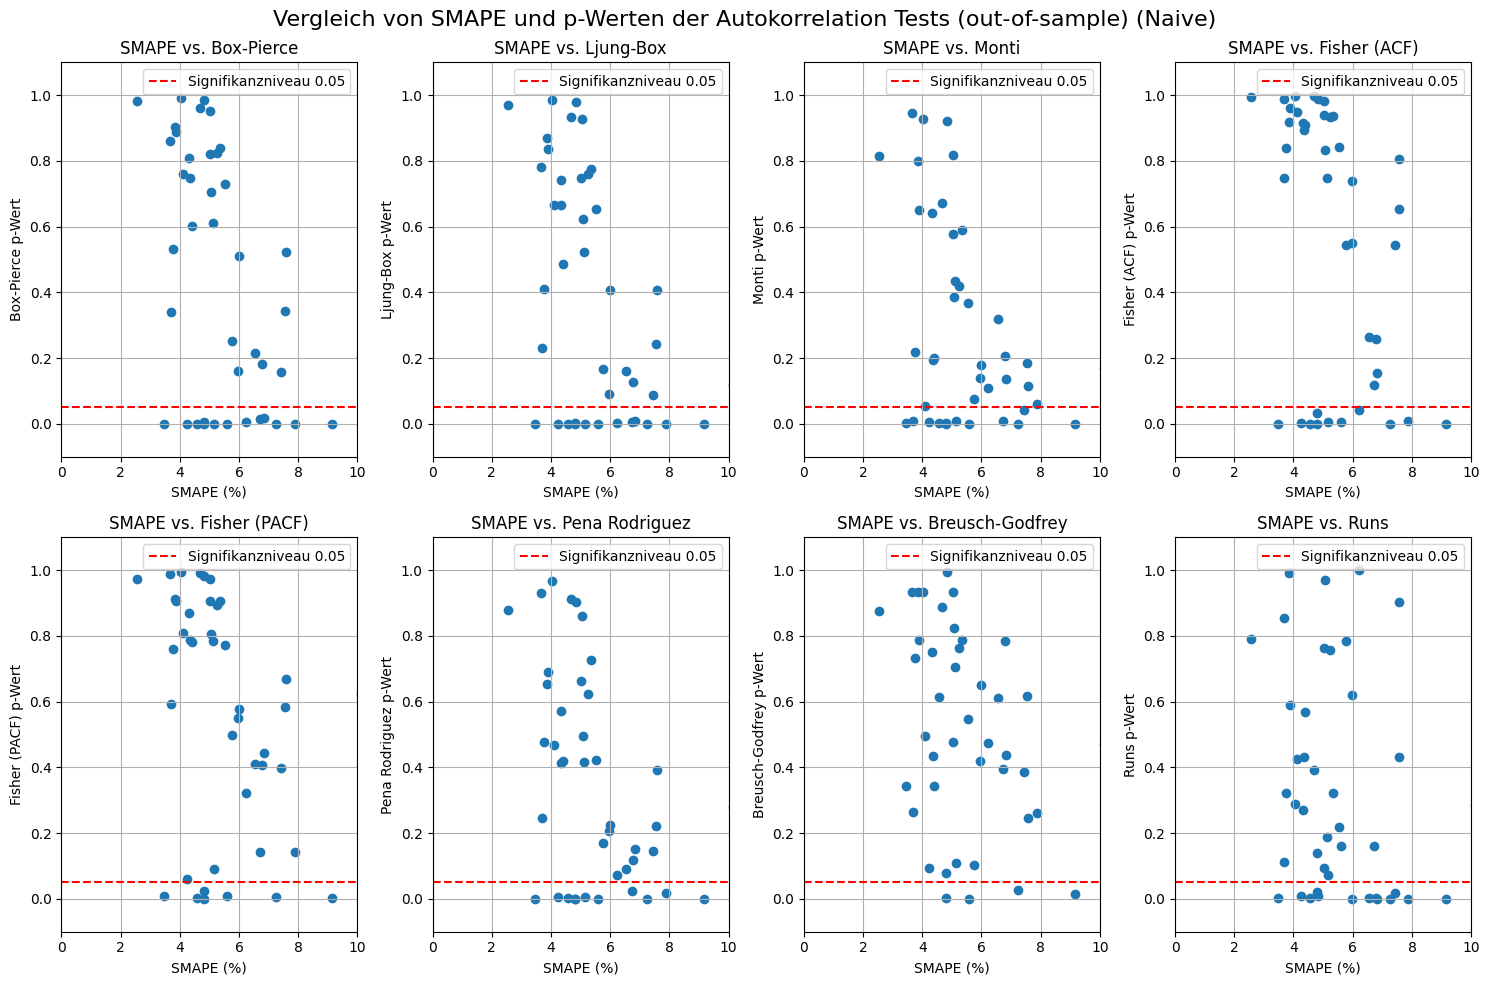

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 Zeilen, 3 Spalten


p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (out-of-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
plt.show()

SMAPE vs. Mittelwert p-Werte

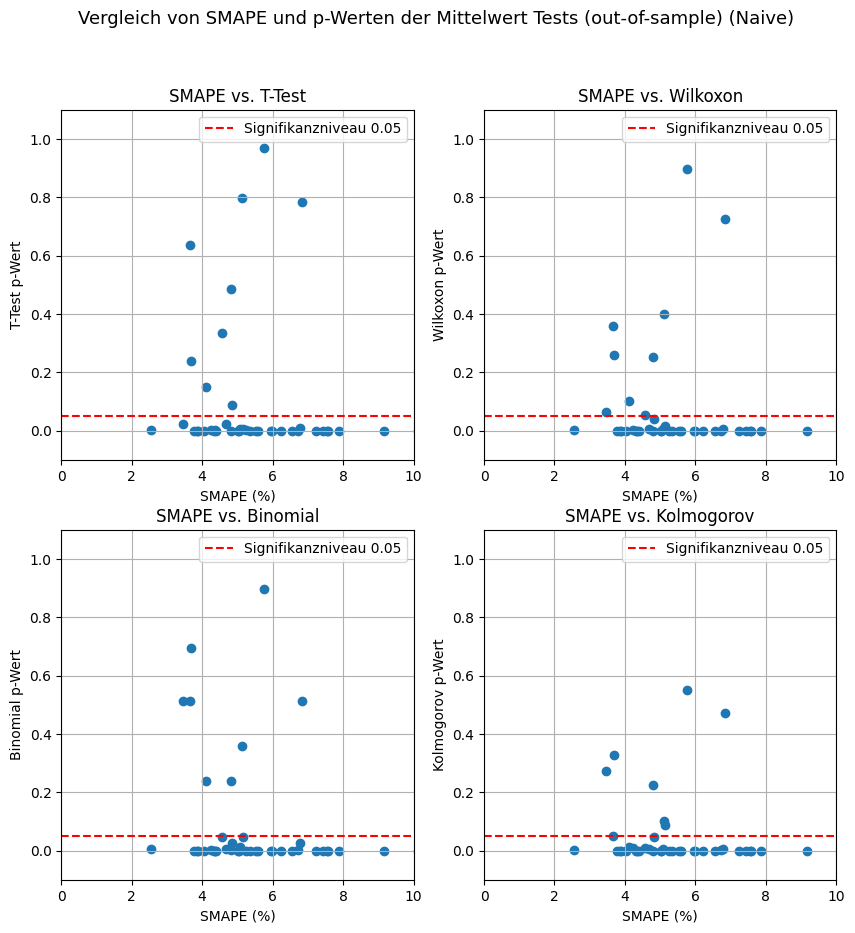

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (out-of-sample) ({})'.format(model_type), fontsize=13)
plt.show()